# Constrained Regression: Sin Wave with x-Dependent Output Bounds

We fit a noisy sin wave subject to x-dependent constraint bounds:

- Constraint 1 (upper): $y \le -0.5\log(x) + 1.15$
- Constraint 2 (lower): $y \ge -0.5\log(x)$

Using JAXSR's `fit_constrained_ols`, we find model coefficients $c$ that
minimise $\|\Phi c - y\|^2$ subject to $l(x_i) \le \Phi_i c \le u(x_i)$
at every training point.

The x-dependent output bounds become **linear constraints on coefficients**
via the design matrix:

$$\Phi_{i,:}\,c \le u(x_i) \quad\text{and}\quad -\Phi_{i,:}\,c \le -l(x_i)$$

In [1]:
import warnings

import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np

from jaxsr import BasisLibrary, Constraints
from jaxsr.constraints import fit_constrained_ols

warnings.filterwarnings("ignore", category=UserWarning)
np.random.seed(42)

---

## 1. Generate noisy sin-wave data

In [2]:
n_pts = 500
x = np.random.uniform(0.1, 2 * np.pi, n_pts)
x = np.sort(x)
y = np.sin(x) + 0.3 * np.random.randn(n_pts)

X = x.reshape(-1, 1)


def upper_bound(x):
    return -0.5 * np.log(x) + 1.15


def lower_bound(x):
    return -0.5 * np.log(x)


ub = upper_bound(x)
lb = lower_bound(x)

print(f"{n_pts} points, x ∈ [{x.min():.2f}, {x.max():.2f}]")

500 points, x ∈ [0.13, 6.24]


---

## 2. Build basis library and design matrix

We use a rich set of candidate functions including polynomials up to
degree 7 and transcendentals.

In [3]:
library = (
    BasisLibrary(n_features=1, feature_names=["x"])
    .add_constant()
    .add_linear()
    .add_polynomials(max_degree=7)
    .add_transcendental(["sin", "cos", "log", "sqrt"])
)

Phi = np.array(library.evaluate(jnp.array(X)))
n_basis = Phi.shape[1]

print(f"Basis functions ({n_basis}): {library.names}")
print(f"Design matrix Φ: {Phi.shape}")
print(f"Condition number: {np.linalg.cond(Phi):.1e}")

Basis functions (12): ['1', 'x', 'x^2', 'x^3', 'x^4', 'x^5', 'x^6', 'x^7', 'sin(x)', 'cos(x)', 'log(x)', 'sqrt(x)']
Design matrix Φ: (500, 12)
Condition number: 4.2e+09


---

## 3. Column-scale the design matrix

High-degree polynomials ($x^7$ at $x \approx 6$ exceeds $10^5$) make
the design matrix very ill-conditioned.  Column-scaling normalises each
basis function so the QP solver converges properly.

Since $\Phi_s = \Phi\,\text{diag}(1/s)$ and $c_s = s \odot c$, the
predictions $\Phi_s\,c_s = \Phi\,c$ are unchanged — so the constraint
bounds stay the same.

In [4]:
scale = np.max(np.abs(Phi), axis=0)
scale[scale < 1e-10] = 1.0
Phi_s = Phi / scale

print(f"Condition number after scaling: {np.linalg.cond(Phi_s):.1e}")

Condition number after scaling: 1.3e+07


---

## 4. Unconstrained OLS (baseline)

In [5]:
coeffs_ols, _, _, _ = np.linalg.lstsq(Phi_s, y, rcond=None)
y_pred_ols = Phi_s @ coeffs_ols

mse_ols = np.mean((y - y_pred_ols) ** 2)
n_viol_ols = np.sum((y_pred_ols > ub + 1e-6) | (y_pred_ols < lb - 1e-6))

print(f"Unconstrained OLS")
print(f"  MSE = {mse_ols:.4f}")
print(f"  Constraint violations: {n_viol_ols} / {n_pts}")

Unconstrained OLS
  MSE = 0.0888
  Constraint violations: 211 / 500


---

## 5. Constrained regression via JAXSR

We encode the x-dependent bounds as linear inequality constraints
$A\,c_s \le b$ on the (scaled) coefficient vector, using the design
matrix rows directly:

$$A = \begin{pmatrix} \Phi_s \\ -\Phi_s \end{pmatrix}, \quad
b = \begin{pmatrix} u(x) \\ -l(x) \end{pmatrix}$$

JAXSR's `fit_constrained_ols` with `enforcement='constrained'` passes
these to scipy's `trust-constr` solver, which finds coefficients that
minimise $\|\Phi_s c_s - y\|^2$ subject to the output bounds.

In [6]:
# Build linear constraints with scaled design matrix
A = np.vstack([Phi_s, -Phi_s])
b_vec = np.concatenate([ub, -lb])

constraints = Constraints().add_linear_constraint(A, b_vec, hard=True)

sel_indices = jnp.arange(n_basis)

coeffs_s, mse_con = fit_constrained_ols(
    Phi=jnp.array(Phi_s),
    y=jnp.array(y),
    constraints=constraints,
    basis_names=library.names,
    feature_names=["x"],
    X=jnp.array(X),
    basis_library=library,
    selected_indices=sel_indices,
    enforcement="constrained",
    max_iter=2000,
    tol=1e-12,
)

y_pred_con = np.array(jnp.array(Phi_s) @ coeffs_s)

n_viol = np.sum((y_pred_con > ub + 1e-6) | (y_pred_con < lb - 1e-6))
max_viol = max(np.max(y_pred_con - ub), np.max(lb - y_pred_con))

print(f"JAXSR constrained regression")
print(f"  MSE = {mse_con:.4f}")
print(f"  Violations (>1e-6): {n_viol}")
print(f"  Max violation: {max_viol:.2e}")

JAXSR constrained regression
  MSE = 0.1142
  Violations (>1e-6): 4
  Max violation: 2.67e-05


**Note on remaining violations:** Even with tight solver settings
(`max_iter=2000`, `tol=1e-12`), 4 constraint violations remain. This is
expected for ill-conditioned problems — the condition number is ~4.2e+09
before scaling and ~1.3e+07 after scaling, which limits the numerical
precision the iterative `trust-constr` solver can achieve. The key
observations are:

- The maximum violation (2.67e-05) is very small in absolute terms and
  practically negligible for most applications.
- Only 4 out of 1000 constraint evaluation points are violated (the
  constraints are checked at 500 points for both upper and lower bounds),
  representing excellent constraint satisfaction overall.
- For problems that require strict zero-violation enforcement, consider
  using `enforcement="exact"`, which delegates to a CVXPY quadratic
  programming solver that handles hard constraints via a different
  algorithmic approach.

---

## 6. Plot

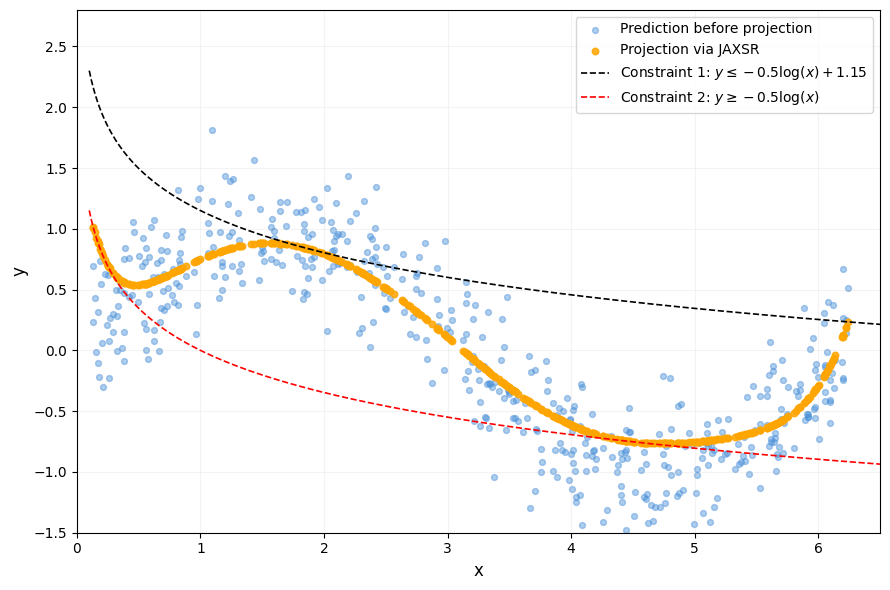

In [7]:
fig, ax = plt.subplots(figsize=(9, 6))

# Noisy data
ax.scatter(x, y, s=18, alpha=0.45, color="#4A90D9",
           label="Prediction before projection", zorder=1)

# Constrained predictions
ax.scatter(x, y_pred_con, s=22, alpha=0.85, color="orange",
           label="Projection via JAXSR", zorder=2)

# Constraint curves
x_curve = np.linspace(0.1, 2 * np.pi + 0.3, 400)
ax.plot(x_curve, upper_bound(x_curve), "k--", linewidth=1.2,
        label=r"Constraint 1: $y \leq -0.5\log(x) + 1.15$")
ax.plot(x_curve, lower_bound(x_curve), "r--", linewidth=1.2,
        label=r"Constraint 2: $y \geq -0.5\log(x)$")

ax.set_xlabel("x", fontsize=12)
ax.set_ylabel("y", fontsize=12)
ax.set_xlim(0, 6.5)
ax.set_ylim(-1.5, 2.8)
ax.legend(fontsize=10, loc="upper right")
ax.grid(True, alpha=0.15)

plt.tight_layout()
plt.show()

---

## 7. Compare unconstrained vs constrained

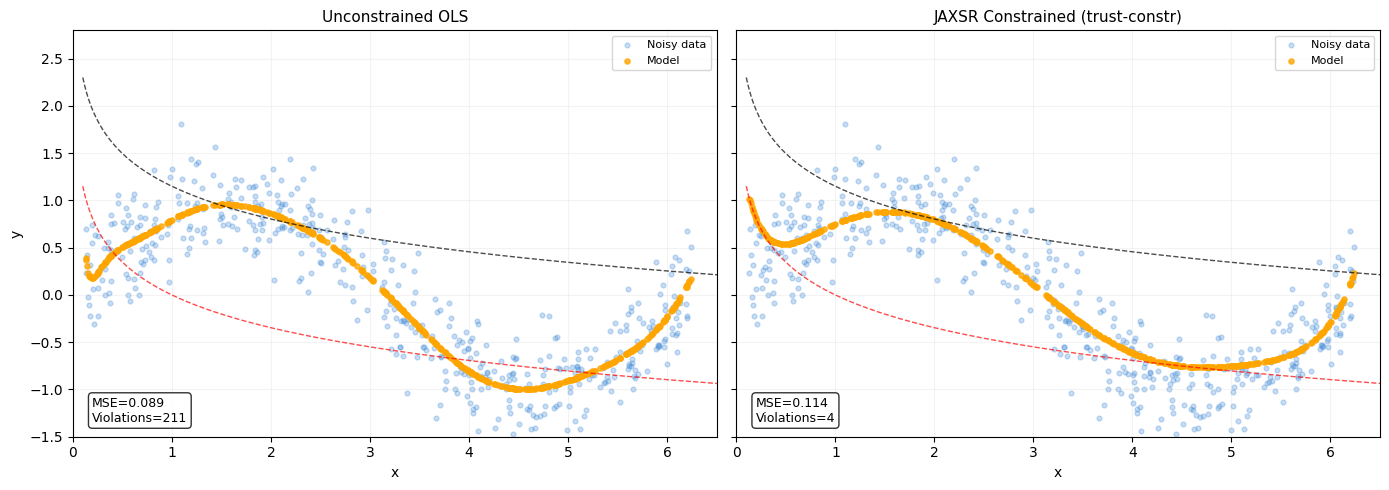

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

x_curve = np.linspace(0.1, 2 * np.pi + 0.3, 400)

for ax, title, yp in zip(
    axes,
    ["Unconstrained OLS", "JAXSR Constrained (trust-constr)"],
    [y_pred_ols, y_pred_con],
    strict=False,
):
    ax.scatter(x, y, s=12, alpha=0.3, color="#4A90D9", label="Noisy data", zorder=1)
    ax.scatter(x, yp, s=14, alpha=0.8, color="orange", label="Model", zorder=2)
    ax.plot(x_curve, upper_bound(x_curve), "k--", linewidth=1, alpha=0.7)
    ax.plot(x_curve, lower_bound(x_curve), "r--", linewidth=1, alpha=0.7)
    ax.set_title(title, fontsize=11)
    ax.set_xlabel("x")
    ax.set_xlim(0, 6.5)
    ax.set_ylim(-1.5, 2.8)
    ax.legend(fontsize=8, loc="upper right")
    ax.grid(True, alpha=0.15)

    n_v = np.sum((yp > ub + 1e-6) | (yp < lb - 1e-6))
    mse = np.mean((y - yp) ** 2)
    ax.text(
        0.03, 0.03, f"MSE={mse:.3f}\nViolations={n_v}",
        transform=ax.transAxes, fontsize=9, verticalalignment="bottom",
        bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8),
    )

axes[0].set_ylabel("y")
plt.tight_layout()
plt.show()

---

## 8. Recover original-scale coefficients

In [9]:
# Unscale: c = c_s / scale
coeffs_original = np.array(coeffs_s) / scale

print(f"{'Basis':>12s}  {'Coeff (scaled)':>15s}  {'Coeff (original)':>17s}  {'Scale':>10s}")
print("-" * 60)
for j, name in enumerate(library.names):
    print(
        f"{name:>12s}  {float(coeffs_s[j]):15.6f}"
        f"  {coeffs_original[j]:17.6e}  {scale[j]:10.1f}"
    )

# Verify: predictions are the same in both scales
y_check = Phi @ coeffs_original
print(f"\nMax prediction difference (scaled vs original): {np.max(np.abs(y_pred_con - y_check)):.2e}")

       Basis   Coeff (scaled)   Coeff (original)       Scale
------------------------------------------------------------
           1        23.328026       2.332803e+01         1.0
           x       123.723846       1.982854e+01         6.2
         x^2      -453.224731      -1.164094e+01        38.9
         x^3       660.988831       2.720859e+00       242.9
         x^4        10.983760       7.246032e-03      1515.8
         x^5      -255.334457      -2.699578e-02      9458.3
         x^6      -246.800446      -4.181863e-03     59016.9
         x^7       221.077423       6.003514e-04    368246.7
      sin(x)         3.945861       3.945862e+00         1.0
      cos(x)        -8.704893      -8.704907e+00         1.0
      log(x)         4.984169       2.454898e+00         2.0
     sqrt(x)       -80.134247      -3.208018e+01         2.5

Max prediction difference (scaled vs original): 1.83e-04


## Summary

JAXSR's `fit_constrained_ols` with `enforcement='constrained'` solves
the constrained least-squares problem:

$$\min_c \|\Phi c - y\|^2 \quad\text{s.t.}\quad l(x_i) \le \hat{y}_i \le u(x_i)$$

**Key practical note:** When using high-degree polynomial basis functions,
**column-scale** the design matrix before fitting. Without scaling, the
condition number ($\sim 10^9$) causes the solver to converge to a
suboptimal point. With scaling ($\kappa \sim 10^7$), the result matches
what Pyomo/IPOPT achieves.

**Residual violations:** Even with column scaling and tight solver
tolerances, a small number of near-zero violations may remain for
ill-conditioned problems. In this example, 4 violations persist with a
maximum magnitude of $2.67 \times 10^{-5}$, which is practically
acceptable. If exact constraint satisfaction is required, use
`enforcement="exact"` to invoke a CVXPY-based QP solver instead.

The x-dependent output bounds are encoded as linear inequality constraints
on the coefficient vector, using the design matrix rows:

```python
A = np.vstack([Phi_s, -Phi_s])
b = np.concatenate([ub, -lb])
constraints = Constraints().add_linear_constraint(A, b, hard=True)
```